In [23]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import platform
from konlpy.tag import Okt
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans

In [24]:
# 한글 폰트 설정
system = platform.system()
if system == 'Darwin':  # macOS
    plt.rc('font', family='AppleGothic')
elif system == 'Windows':
    plt.rc('font', family='Malgun Gothic')
else:  # Linux
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in ['NanumGothic', 'NanumBarunGothic', 'UnDotum', 'UnBatang', 'Gulim']:
        if font in available_fonts:
            plt.rc('font', family=font)
            break
plt.rc('axes', unicode_minus=False)

In [25]:
from Korpora import Korpora

# 사용 가능한 말뭉치 목록 확인
Korpora.corpus_list()

# 특정 말뭉치 다운로드 예시 (카카오브레인의 STS 데이터)
Korpora.fetch("korsts")
corpus = Korpora.load("korsts")


[Korpora] Corpus `korsts` is already installed at /Users/bagjuhyeon/Korpora/korsts/sts-train.tsv
[Korpora] Corpus `korsts` is already installed at /Users/bagjuhyeon/Korpora/korsts/sts-dev.tsv
[Korpora] Corpus `korsts` is already installed at /Users/bagjuhyeon/Korpora/korsts/sts-test.tsv

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/kakaobrain/KorNLUDatasets
    References :
        - Ham, J., Choe, Y. J., Park, K., Choi, I., & Soh, H. (2020). KorNLI and KorSTS: New Benchmark
           Datasets for Korean Natural Language Understanding. arXiv preprint arXiv:2004.03289.
           (https://arxiv.org/abs/2004.03289)

    This is the dataset repository for our paper
    "KorNLI and KorSTS: New Benchmark Datasets for Ko

In [26]:
corpus.train.texts

('비행기가 이륙하고 있다.',
 '한 남자가 큰 플루트를 연주하고 있다.',
 '한 남자가 피자에 치즈를 뿌려놓고 있다.',
 '세 남자가 체스를 하고 있다.',
 '한 남자가 첼로를 연주하고 있다.',
 '몇몇 남자들이 싸우고 있다.',
 '남자가 담배를 피우고 있다.',
 '남자가 피아노를 치고 있다.',
 '한 남자가 기타를 치고 노래를 부르고 있다.',
 '사람이 고양이를 천장에 던지고 있다.',
 '그 남자는 다른 남자를 막대기로 때렸다.',
 '한 여성이 아기를 안아서 캥거루를 안는다.',
 '남자가 플루트를 연주하고 있다.',
 '사람이 종이 한 장을 접고 있다.',
 '한 남자가 도로를 달리고 있다.',
 '개가 베이컨을 등에서 떼려고 하고 있다.',
 '북극곰이 눈 위에서 미끄러지고 있다.',
 '여자가 글을 쓰고 있다.',
 '고양이가 아기의 얼굴을 문지르고 있다.',
 '남자가 말을 타고 있다.',
 '한 남자가 냄비에 기름을 부어 넣는다.',
 '남자가 기타를 치고 있다.',
 '판다가 슬라이드 아래로 미끄러져 내려간다.',
 '여자가 뭔가를 먹고 있다.',
 '한 여자가 감자 껍질을 벗긴다.',
 '그 소년은 자전거에서 떨어졌다.',
 '여자가 플루트를 연주하고 있다.',
 '토끼가 독수리에게서 뛰고 있다.',
 '여자가 빵을 곁들인 돼지고기를 튀기고 있다.',
 '한 소녀가 연을 날리고 있다.',
 '한 남자가 기계식 황소를 타고 있다.',
 '남자가 기타를 연주하고 있다.',
 '한 여성이 다른 여성들과 춤추고 노래하고 있다.',
 '남자가 빵을 자르고 있다.',
 '남자가 팬에 기름을 부어 넣고 있다.',
 '사자가 사람들과 놀고 있다.',
 '개가 스케이트보드를 탄다.',
 '누군가가 동상을 조각하고 있다.',
 '한 여성이 양파를 자르고 있다.',
 '여자는 새우 껍질을 벗긴다.',
 '한 여성이 생선 튀김을 하고 있다.',
 '한 여성이 일렉트릭 기타를 연주하고 있다.',
 '새끼 호랑이가 공을 가지고 놀고 있다.',
 '사

In [27]:
# stop_words 파일 읽기
filepath = "./datasets/korean_stop_words.txt"
stop_words = []
f = open(filepath, 'r')
while True:
    line = f.readline()
    if not line: break
    stop_words.append(line.split("\t")[0])
f.close()
stop_words

['이',
 '있',
 '하',
 '것',
 '들',
 '그',
 '되',
 '수',
 '이',
 '보',
 '않',
 '없',
 '나',
 '사람',
 '주',
 '아니',
 '등',
 '같',
 '우리',
 '때',
 '년',
 '가',
 '한',
 '지',
 '대하',
 '오',
 '말',
 '일',
 '그렇',
 '위하',
 '때문',
 '그것',
 '두',
 '말하',
 '알',
 '그러나',
 '받',
 '못하',
 '일',
 '그런',
 '또',
 '문제',
 '더',
 '사회',
 '많',
 '그리고',
 '좋',
 '크',
 '따르',
 '중',
 '나오',
 '가지',
 '씨',
 '시키',
 '만들',
 '지금',
 '생각하',
 '그러',
 '속',
 '하나',
 '집',
 '살',
 '모르',
 '적',
 '월',
 '데',
 '자신',
 '안',
 '어떤',
 '내',
 '내',
 '경우',
 '명',
 '생각',
 '시간',
 '그녀',
 '다시',
 '이런',
 '앞',
 '보이',
 '번',
 '나',
 '다른',
 '어떻',
 '여자',
 '개',
 '전',
 '들',
 '사실',
 '이렇',
 '점',
 '싶',
 '말',
 '정도',
 '좀',
 '원',
 '잘',
 '통하',
 '소리',
 '놓']

In [28]:
# 형태소 분석기 초기화
okt = Okt()

# 토큰화 함수
def preprocess_text(text):
    # 정규화 (한글 외 문자 제거)
    text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)
    
    # 형태소 분석
    tokens = okt.morphs(text, stem=True)
    
    # 불용어 제거
    tokens = [word for word in tokens if not word in stop_words]
    
    return tokens

# 예시 데이터
#texts = ['한국어 텍스트 예시입니다', '단어 임베딩을 시각화해 봅시다']
tokenized_data = [preprocess_text(text) for text in corpus.train.texts]


In [29]:
# Word2Vec 모델 학습
model = Word2Vec(sentences=tokenized_data, 
                 sg=1,  # 1: skip-gram, 0: CBOW
                 vector_size=100,  # 벡터 차원
                 window=5,         # 컨텍스트 윈도우 크기
                 min_count=1,      # 최소 단어 빈도
                 workers=8)        # 병렬 처리 스레드 수

# 모델 저장
model.save('word2vec_STS.model')

# 필요시 모델 로드
# model = Word2Vec.load('word2vec_model.model')


In [30]:
model.wv.index_to_key

['하다',
 '을',
 '있다',
 '에',
 '를',
 '의',
 '은',
 '는',
 '에서',
 '남자',
 '로',
 '으로',
 '되다',
 '하고',
 '이다',
 '사망',
 '과',
 '와',
 '여성',
 '인',
 '명의',
 '대한',
 '고',
 '미국',
 '않다',
 '되어다',
 '위',
 '시리아',
 '위해',
 '다',
 '달러',
 '중국',
 '마리',
 '공격',
 '받다',
 '에게',
 '앉다',
 '러시아',
 '대통령',
 '대해',
 '후',
 '타고',
 '서다',
 '소녀',
 '없다',
 '자르다',
 '세',
 '이란',
 '늘다',
 '이스라엘',
 '갈색',
 '소년',
 '크다',
 '따르다',
 '치고',
 '들다',
 '주식',
 '이라고',
 '경찰',
 '폭탄',
 '이집트',
 '입다',
 '새롭다',
 '검다',
 '정부',
 '기타',
 '고양이',
 '파키스탄',
 '동안',
 '아프가니스탄',
 '기록',
 '많다',
 '혐의',
 '자',
 '시키다',
 '인도',
 '눈',
 '가다',
 '물',
 '아이',
 '연주',
 '살해',
 '시위',
 '테러',
 '체포',
 '타다',
 '보고',
 '및',
 '상승',
 '어리다',
 '영국',
 '오바마',
 '사용',
 '충돌',
 '회담',
 '놀다',
 '달리',
 '계획',
 '작다',
 '흑백',
 '선거',
 '만',
 '무기',
 '증가',
 '핵',
 '당신',
 '걷다',
 '하락',
 '발견',
 '자전거',
 '주장',
 '세계',
 '지수',
 '새',
 '아니다',
 '거래',
 '이라크',
 '지역',
 '보다',
 '팔레스타인',
 '약',
 '나무',
 '부상',
 '억',
 '비행기',
 '프랑스',
 '주다',
 '즉',
 '도',
 '투표',
 '넣다',
 '빨갛다',
 '사망자',
 '시작',
 '요구',
 '퍼센트',
 '비난',
 '무장',
 '희다',
 '버스',
 '카메라',
 '폭발',

In [31]:
def remove_stop_words(words, stop_words):
    return [word for word in words if word not in stop_words]

In [32]:
# 인터랙티브 3D 시각화
def interactive_3d_visualization(model, words=None, topN=100):
    """
    인터랙티브 3D 시각화 (plotly 사용)
    
    Args:
        model: Word2Vec 모델
        words: 시각화할 단어 목록 (None이면 모델의 상위 단어 사용)
        topn: words가 None일 때 사용할 상위 단어 수
    """

    # 단어 목록 준비
    if words is None:
        available_words = len(model.wv.index_to_key)
        actual_topn = min(topN, available_words)
        words = [word for word in model.wv.index_to_key[:actual_topn]]
    else:
        words = [word for word in words if word in model.wv]
    
    # 단어 벡터 추출
    word_vectors = np.array([model.wv[word] for word in words])
    
    # perplexity 값 자동 조정
    n_samples = len(words)
    perplexity = min(max(5, n_samples // 4), n_samples - 1)
    
    # 3차원 t-SNE 적용
    tsne = TSNE(n_components=3, random_state=42, max_iter=1000, perplexity=perplexity)
    embeddings_3d = tsne.fit_transform(word_vectors)
    
    # 데이터프레임 생성
    df = pd.DataFrame({
        'word': words,
        'x': embeddings_3d[:, 0],
        'y': embeddings_3d[:, 1],
        'z': embeddings_3d[:, 2]
    })

    # 클러스터링
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(embeddings_3d)
    df['cluster'] = kmeans.labels_
    
    # Plotly 3D 산점도 생성
    fig = px.scatter_3d(df, x='x', y='y', z='z', text='word',
                       title='Word2Vec 단어 임베딩 3D 시각화 (t-SNE)',
                       opacity=0.7, color='cluster')
    
    # 텍스트 레이블 추가
    fig.update_traces(textposition='top center')
    
    # 레이아웃 설정
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=900,
        height=800,
        margin=dict(l=0, r=0, b=0, t=30)
    )
    
    fig.show()
    
    return fig, df

In [33]:
def w2v_visualization(model, words=None, topN=1000):
    # 불용어 제거
    words = remove_stop_words(model.wv.index_to_key[:topN], stop_words)
    # 인터랙티브 3D 시각화 (plotly 필요)
    interactive_3d_visualization(model, words=words)        

In [34]:
w2v_visualization(model)

In [36]:
model.wv.index_to_key
country = ['미국', '중국', '시리아', '러시아', '이스라엘']
person = ['소녀', '소년', '경찰']

In [19]:
# 필요한 라이브러리 임포트
import torch
from transformers import BertModel
import numpy as np
import matplotlib.pyplot as plt
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1', sp_model_kwargs={'nbest_size': -1, 'alpha': 0.6, 'enable_sampling': True})
tokenizer.encode("한국어 모델을 공유합니다.")


model = BertModel.from_pretrained('skt/kobert-base-v1')
text = "한국어 모델을 공유합니다."
inputs = tokenizer.batch_encode_plus([text])
out = model(input_ids = torch.tensor(inputs['input_ids']),
              attention_mask = torch.tensor(inputs['attention_mask']))
out.pooler_output.shape

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


torch.Size([1, 768])

In [3]:
out

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1554, -0.0150,  0.3673,  ..., -0.0094,  0.1067,  0.0844],
         [ 0.1229, -0.3236, -0.0669,  ..., -0.4487, -0.1753, -0.2302],
         [ 0.1008, -0.3885, -0.1219,  ..., -0.2129, -0.0330, -0.1708],
         ...,
         [-0.0700,  0.1174, -0.1385,  ..., -0.0272,  0.5141, -0.0093],
         [-0.0605, -0.2776,  0.4285,  ..., -0.2879,  0.5493,  0.0797],
         [-0.1537, -0.1819, -0.1994,  ..., -0.2862,  0.0133,  0.0783]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-1.5197e-02,  1.2525e-02, -2.0906e-02, -4.9571e-02, -9.7731e-01,
          9.9156e-01, -6.7530e-01,  5.5347e-02,  2.3231e-02,  4.5099e-03,
         -5.1811e-01, -3.6802e-02, -4.0091e-02, -7.1836e-02, -2.3317e-02,
          8.3534e-01, -9.9642e-01,  5.2745e-02,  2.5370e-03, -8.5500e-02,
          1.1586e-01, -4.6590e-02, -2.1022e-02,  5.6610e-01,  3.4027e-02,
          7.5982e-01, -9.3067e-01, -6.7136e-02, -9.6185e-01, -1.712

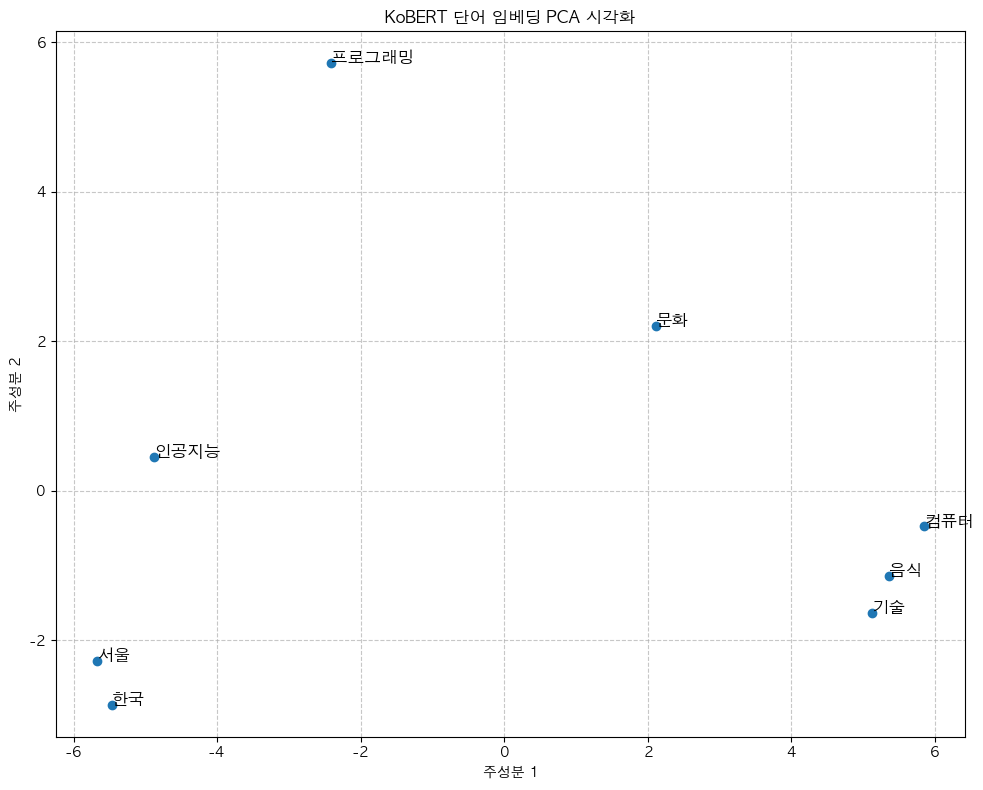

단어 쌍 유사도:


In [22]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
def get_word_embeddings(words, model, tokenizer):
    """
    단어 리스트에서 임베딩을 추출합니다.
    
    Args:
        words: 임베딩을 추출할 단어 리스트
        model: 사전 훈련된 모델
        tokenizer: 모델에 맞는 토크나이저
        
    Returns:
        단어별 임베딩 (numpy 배열)
    """
    model.eval()
    word_embeddings = {}
    
    for word in words:
        # 토큰화
        inputs = tokenizer(word, return_tensors="pt")
        
        # 그래디언트 계산 없이 순전파
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 단어 토큰의 임베딩 추출 (첫 번째 토큰 사용)
        # 서브워드 토크나이징으로 인해 하나의 단어가 여러 토큰으로 나뉠 수 있음
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        token_embeddings = outputs.last_hidden_state[0].numpy()
        
        # 첫 번째 토큰(서브워드)의 임베딩만 사용
        # [CLS] 토큰을 제외하고 실제 단어의 첫 번째 토큰은 인덱스 1에 위치
        word_embeddings[word] = token_embeddings[1]
    
    return word_embeddings

# 테스트할 한국어 단어들
words = ["한국", "서울", "인공지능", "컴퓨터", "프로그래밍", "음식", "문화", "기술"]

# 단어 임베딩 추출
word_embeddings = get_word_embeddings(words, model, tokenizer)

# 단어 임베딩 시각화 (2D PCA)
word_vectors = np.array([word_embeddings[word] for word in words])
pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=12)

plt.title('KoBERT 단어 임베딩 PCA 시각화')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 단어 간 유사도 계산
word_similarity = cosine_similarity(word_vectors)

# 각 단어 쌍의 유사도 출력
print("단어 쌍 유사도:")
for i in range(len(words)):
    for j in range(i+1, len(words)):
       # print(f"'{words[i]}'와(과) '{words[j]}'의 유사도: {word_similarity[i][j]:.4f}")
       continue


In [21]:
word_embeddings

{'한국': array([ 1.78188831e-01,  3.77724580e-02,  9.36974883e-02, -2.99556804e+00,
        -1.57856181e-01, -3.07849020e-01,  1.52589619e-01,  3.59864295e-01,
        -5.52342176e-01,  1.19322374e-01,  5.85000992e-01, -1.08772084e-01,
         4.06275004e-01,  1.80389896e-01,  1.13933787e-01, -4.65157256e-02,
         4.64609750e-02, -2.90861934e-01, -5.09107709e-01,  1.19734913e-01,
        -7.37124681e-02,  6.14431873e-02,  1.06594913e-01,  3.15405875e-01,
        -4.82732594e-01,  3.92017573e-01, -6.10954404e-01,  5.25152683e-01,
        -3.98596972e-01, -3.00585300e-01, -6.45142198e-02, -9.46508497e-02,
        -1.04857773e-01,  3.72874402e-02, -1.70743629e-01,  1.84575453e-01,
        -9.23258066e-02,  3.86925131e-01, -2.37136513e-01, -1.28326073e-01,
         2.34879777e-01,  7.70354494e-02, -4.07172501e-01,  1.85293078e-01,
         5.93817644e-02,  2.15604678e-01,  2.06227258e-01, -6.99758381e-02,
        -1.06692731e-01,  1.76684231e-01, -1.05456501e-01,  3.91365290e-01,
      